## Setup

In [ ]:
#| code-fold: true
#| code-summary: "Show pip installs"
!pip install torch==2.3.1 -qq
!pip install accelerate==0.31.0 -qq
!pip install transformers==4.41.2 -qq
!pip install huggingface_hub -qq
!pip install datasets~=2.16.1 -qq
!pip install plotly==5.19.0 -qq
!pip install scikit-learn==1.2 -qq

In [ ]:
#| code-fold: true
#| code-summary: "Show imports and setup"
import gc
import pandas as pd
import numpy as np
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import torch

import warnings
#warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import time

from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline 
from transformers.pipelines.pt_utils import KeyDataset
from fastcore.all import *

#torch.set_default_device("cuda")
torch.cuda.set_device(0)

model = AutoModelForCausalLM.from_pretrained( 
    "microsoft/Phi-3-mini-4k-instruct",  
    device_map="cuda",  
    torch_dtype="auto",  
    trust_remote_code=True,  
) 

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

pipe = pipeline( 
    "text-generation", 
    model=model, 
    tokenizer=tokenizer, 
) 

# load dataset
dataset = load_dataset(
    "financial_phrasebank", "sentences_allagree", 
    split="train"  # note that the dataset does not have a default test split
)

In [ ]:
# create a new column with the numeric label verbalised as label_text (e.g. "positive" instead of "0")
label_map = {i: label_text for i, label_text in enumerate(dataset.features["label"].names)}

def add_label_text(example):
    example["label_text"] = label_map[example["label"]]
    return example

dataset = dataset.map(add_label_text)

print(dataset)

In [5]:
#| code-fold: true
#| code-summary: "Show `add_prompt` and `generate_responses` functions"
def add_prompt(item, prompt):
        item['prompt'] = prompt.format(text=item['sentence'])
        return item
    
def generate_responses(dataset, prompt):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    
    # check that the prompt is correctly formatted
    print(dataset[0]['prompt'])
    print('---------')
    
    for row in dataset:
        messages = [  
            {"role": "user", "content": row['prompt']},
        ] 

        generation_args = { 
            "max_new_tokens": 2, 
            "return_full_text": False, 
            "temperature": 0.1, 
            "do_sample": True, 
        } 

        response = pipe(messages, **generation_args) 
        responses.append(response[0]['generated_text'].strip().lower())
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    return df, acc

In [6]:
#| code-fold: true
#| code-summary: "Show `generate_response` function"
def generate_response(prompt):
    messages = [  
        {"role": "user", "content": prompt},
    ] 

    generation_args = { 
        "max_new_tokens": 2, 
        "return_full_text": False, 
        "temperature": 0.1, 
        "do_sample": True, 
    } 

    output = pipe(messages, **generation_args) 
    return output[0]['generated_text']

In [7]:
#| code-fold: true
#| code-summary: "Show `make_cm` function"
def make_cm(df):
    """Create confusion matrix for true vs predicted sentiment classes"""
    
    cm = confusion_matrix(y_true=df['label_text'], y_pred=df['responses'], labels=['negative', 'neutral', 'positive', 'other'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive', 'other'])
    
    # I chose 8x8 so it fits on one screen but still is large
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax,text_kw={'fontsize': 16}, cmap='Blues', colorbar=False);
    
    # change label font size without changing label text
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    
    # make tick labels larger
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)

In [8]:
#| code-fold: true
#| code-summary: "Show `ds_subset` function"
def ds_subset(dataset, exclude_idxs, columns=[0, 1, 2]):
    idxs = list(range(len(dataset)))
    idxs = [x for x in idxs if x not in exclude_idxs]
    ddf = dataset.to_pandas()
    new_ds = Dataset.from_pandas(ddf.iloc[idxs, columns])
    return new_ds

## Background

In this notebook I'll use [Phi-3-mini-4k-instruct](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct) to classify sentiment in the [`financial_phrasebank` dataset](https://huggingface.co/datasets/financial_phrasebank).
In previous notebooks I have performed [sentiment classification with phi-2](https://vishalbakshi.github.io/blog/posts/2024-08-31-tinysentiment-phi-2-sentiment-classification/) and [the Claude series](https://vishalbakshi.github.io/blog/posts/2024-08-29-tinysentiment-claude-experiments/).

This notebook is part of [a series of blog posts](https://vishalbakshi.github.io/blog/#category=TinySentiment) for a project I’m working called TinySentiment where I’m experimenting with tiny models to improve their ability to classify sentiment in the `financial_phrasebank dataset`. I was inspired to do so after reading [this blog post](https://huggingface.co/blog/synthetic-data-save-costs) and [this corresponding notebook](https://github.com/MoritzLaurer/synthetic-data-blog/blob/main/notebooks/synthetic_data_creation.ipynb) by Moritz Laurer as part of a fastai study group last year.

Here are the results from my experiments so far (\**the best-performing prompt from this notebook):

|Model|Prompting Strategy|Overall Accuracy|`negative`|`neutral`|`positive`|
|:-:|:-:|:-:|:-:|:-:|:-:|
|claude-3-5-sonnet-20240620|3-Shot|94.78%|98% (297/303) | 94% (1302/1391)|95% (544/570)|
|claude-3-opus-20240229|0-Shot|94.13%|98% (297/303)|96% (1333/1391)|88% (501/570)|
|phi-3.5|20-Shot|93.94%|96% (286/299)|98% (1355/1379)|83% (467/566)|
|\**phi-3|30-Shot w/System Prompt|92.79%|98% (290/297)|94% (1284/1373)|88% (499/564)|
|claude-3-haiku-20240307|3-Shot|92.39%|90% (272/303)|91% (1267/1391)|96% (550/570)|
|phi-2|6-Shot|91.94%|88% (267/302)|94% (1299/1387)|90% (510/569)|


Here are the per-prompt results from this notebook (phi-3):

|prompt|strategy|accuracy|negative|neutral|positive|
|:-:|:-:|:-:|:-:|:-:|:-:|
|[A](#prompt-A)|0-Shot|47.00%|98% (298/303)|16% (220/1391)|96% (546/570)|
|[B](#prompt-B)|0-Shot|73.23%|99% (300/303)|59% (821/1391)|94% (537/570)|
|[C](#prompt-C)|0-Shot|66.25%|99% (300/303)|47% (650/1391)|96% (550/570)|
|[D](#prompt-D)|0-Shot|49.65%|<u>**99% (301/303)**</u>|19% (269/1391)|97% (554/570)|
|[E](#prompt-E)|0-Shot|72.44%|99% (299/303)|58% (803/1391)|94% (538/570)|
|[F](#prompt-F)|3-Shot|82.62%|98% (297/302)|73% (1009/1390)|99% (562/569)|
|[G](#prompt-G)|6-Shot|76.13%|98% (297/302)|62% (865/1387)|98% (557/569)|
|[H](#prompt-H)|3-Shot|83.10%|98% (296/302)|73% (1021/1390)|99% (562/569)|
|[I](#prompt-I)|3-Shot|81.16%|98% (295/302)|70% (977/1390)|99% (563/569)|
|[J](#prompt-J)|3-Shot|84.61%|97% (294/302)|76% (1055/1390)|<u>**99% (564/569)<u>**|
|[K](#prompt-K)|3-Shot|83.19%|98% (295/302)|74% (1024/1390)|99% (562/569)|
|[L](#prompt-L)|3-Shot w/System Prompt|87.35%|98% (295/302)|81% (1120/1390)|98% (560/569)|
|[M](#prompt-M)|3-Shot w/System Prompt|88.41%|97% (292/302)|83% (1149/1390)|98% (558/569)|
|[N](#prompt-N)|3-Shot w/System Prompt|88.28%|97% (293/302)|82% (1142/1390)|99% (561/569)|
|[O](#prompt-O)|3-Shot w/System Prompt|88.59%|98% (296/302)|82% (1145/1390)|99% (562/569)|
|[P](#prompt-P)|3-Shot w/System Prompt|90.00%|97% (294/302)|85% (1179/1390)|99% (562/569)|
|[Q](#prompt-Q)|20-Shot w/System Prompt|91.71%|97% (291/299)|89% (1226/1379)|96% (541/566)|
|<u>**[R](#prompt-R)**</u>|<u>**30-Shot w/System Prompt**</u>|<u>**92.79%**</u>|98% (290/297)|<u>**94% (1284/1373)**</u>|88% (499/564)|


## Prompt A

The HuggingFace model card for Phi-3 Mini-4K-Instruct says:

> Given the nature of the training data, the Phi-3 Mini-4K-Instruct model is best suited for prompts using the chat format

So, the first prompt I'll try will be a simple instruction:



In [7]:
promptA = """Label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}"""

In [8]:
text = dataset[1]["sentence"]
text

"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ."

In [9]:
formatted_prompt = promptA.format(text=text)
print(formatted_prompt)

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .


In [10]:
generate_response(formatted_prompt)

You are not running the flash-attention implementation, expect numerical differences.


' Negative'

In [11]:
%time generate_response(formatted_prompt)

CPU times: user 64.3 ms, sys: 87 µs, total: 64.4 ms
Wall time: 63.5 ms


' Negative'

In [12]:
%timeit -n 10 generate_response(formatted_prompt)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


60.1 ms ± 926 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Good--at least it works! Although it looks like I'll have to strip the 
outputs of whitespace and convert them to lowercase. It takes about 0.06 seconds to generate
the response, so it should take about 2-3 minutes to run inference on the whole dataset.

In [19]:
df, acc = generate_responses(dataset, promptA)

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
---------


As expected, the model does not perform well with this prompt. It actually performs worse
than phi-2 (58%).

In [20]:
acc

0.46996466431095407

The model actually performs quite well for `negative` (298/393) and `positive` (546/570) sentiment, but performs badly for `neutral` sentiment (220/1391).

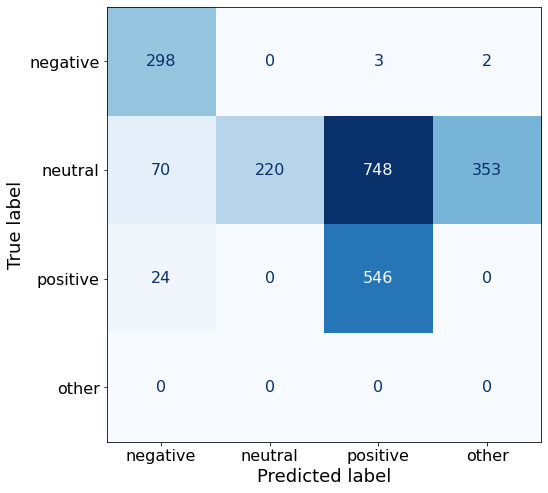

In [22]:
make_cm(df)

In [23]:
df.to_csv('/notebooks/phi-3_A.csv', index=False)

## Prompt B

I'll repeat the instruction after the sentence and see if that improves the performance (as it did for phi-2).

In [38]:
promptB = """Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral"""

In [39]:
df, acc = generate_responses(dataset, promptB)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
---------


As expected, repeating the instruction boosts the accuracy significantly. This is something
I learned to do in a fastai study group.

In [40]:
acc

0.7323321554770318

The model improves its performance for `negative` and `neutral` sentences, while its
performance for `positive` sentences worsens.

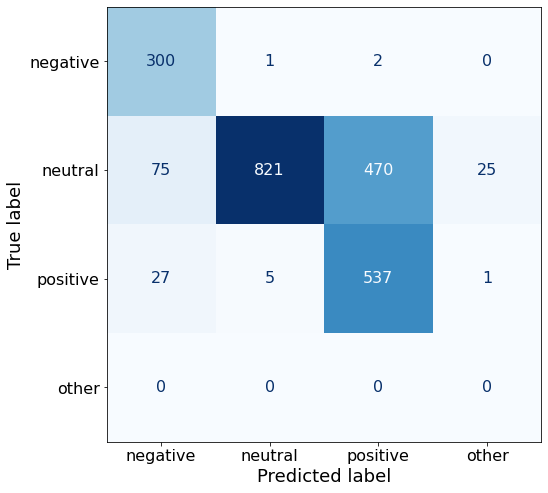

In [42]:
make_cm(df)


In [43]:
df.to_csv('/notebooks/phi-3_B.csv', index=False)

## Prompt C

I'll add some introductory text to the prompt to see if that improves the model's performance:

In [28]:
promptC = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral"""

In [29]:
df, acc = generate_responses(dataset, promptC)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral
---------


Unlike phi-2 (although I applied this introductory text to few-shot prompting, not 0-shot) 
this worsens the model's overall accuracy.

In [30]:
acc

0.6625441696113075

Interestingly, this prompt improves the `positive` sentiment true positive rate (550/570 > 537/570).

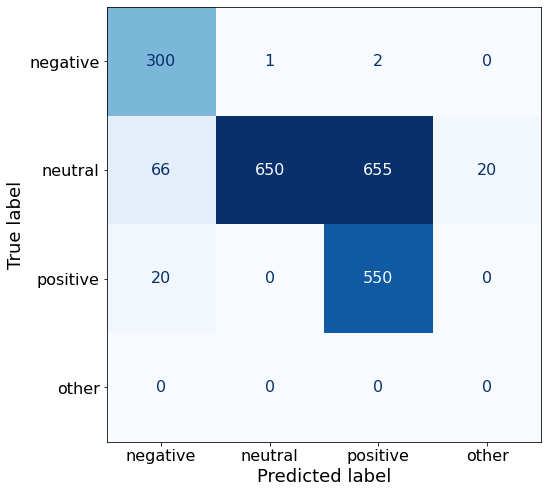

In [31]:
make_cm(df)

In [33]:
df.to_csv('/notebooks/phi-3_C.csv', index=False)

## Prompt D

I'll try another prompt language adjustment to Prompt B: I'll replace
"label" with "Respond".

In [34]:
promptD = """Instruct: Respond with only one of these words: negative, positive, or neutral
TEXT: {text}
Respond with only one of these words: negative, positive, or neutral"""

In [35]:
df, acc = generate_responses(dataset, promptD)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: Respond with only one of these words: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral
---------


Yikes! The overall accuracy plummets to 49.6%. 

In [36]:
acc

0.49646643109540634

Interestingly, the true positive rate for `negative` and `positive` sentences increses,
but for `neutral` _significantly_ decreases.

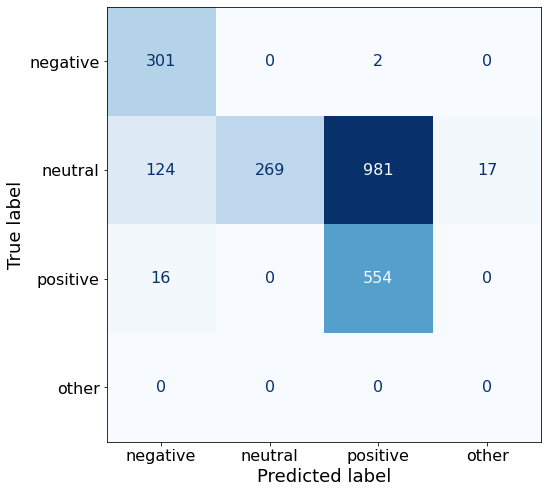

In [37]:
make_cm(df)

In [38]:
df.to_csv('/notebooks/phi-3_D.csv', index=False)

## Prompt E

Another adjustment that improved phi-2's performance was to add a period after the instruction. I'll see
if doing so improves phi-3's performance.

In [10]:
promptE = """Instruct: label the following TEXT with a single word: negative, positive, or neutral.
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral."""

In [11]:
df, acc = generate_responses(dataset, promptE)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral.
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral.
---------


You are not running the flash-attention implementation, expect numerical differences.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


The accuracy drops from 73% to 72%.

In [12]:
acc

0.7243816254416962

The true positive rate for `negative` and `neutral` 
sentiment drops a bit while for `positive` sentiments increases (538/570 > 537/570).

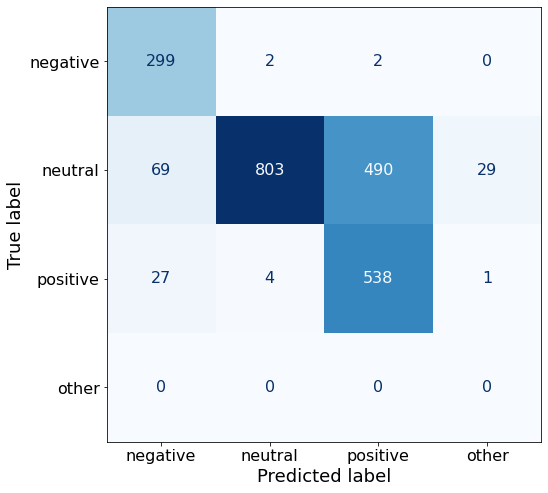

In [13]:
make_cm(df)

In [14]:
df.to_csv('/notebooks/phi-3_E.csv', index=False)

## Prompt F

I'll now move on to few-shot prompting to see if I can improve on the best overall accuracy so far (73.1%).
To do so, I'll create a new helper function (since the chat template handles few-shot prompt as multiple query-response exchanges between user and assistant).

In [15]:
#| code-fold: true
#| code-summary: "Show `few_shot_responses` function"
def few_shot_responses(dataset, prompt, examples):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})

    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    count = 0
    for row in dataset:
        count += 1
        messages = few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        if count == 1: print(messages)
        
        generation_args = { 
            "max_new_tokens": 2, 
            "return_full_text": False, 
            "temperature": 0.1, 
            "do_sample": True, 
        } 

        response = pipe(messages, **generation_args) 
        responses.append(response[0]['generated_text'].strip().lower())
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    return df, acc

In [17]:
exclude_idxs = [0, 1, 292]

In [18]:
promptF_ds = ds_subset(dataset, exclude_idxs)
promptF_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2261
})

In [19]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples

[('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'),
 ("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 ('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
  'negative')]

In [20]:
df, acc = few_shot_responses(promptF_ds, promptB, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'user', 'content': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nlabel the TEXT with a single word: negative, positive, or neutral'}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nlabel the TEXT with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'positive'}, {'role': 'user', 'content': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a su

Nice! Few-shot prompting improves the overall accuracy by almost 10% (from 73.06% to 82.62%).

In [21]:
acc

0.8261831048208758

Compared to prompt B, this prompt yields worse results for `negative` sentiment (297 < 300),
and better results for `neutral` (1009 > 817) and `positive` sentiment (562 > 537).

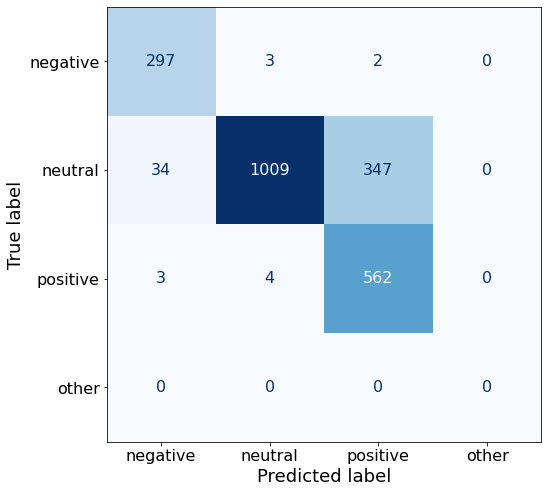

In [22]:
make_cm(df)

In [23]:
df.to_csv('/notebooks/phi-3_F.csv', index=False)

## Prompt G

I'll now try a 6-Shot prompt using the examples that were best-performing for phi-2.

In [24]:
exclude_idxs=[0, 1, 292, 37, 38, 39]
promptG_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptG_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2258
})

In [25]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples[0], len(examples)

(('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'),
 6)

In [26]:
df, acc = few_shot_responses(promptG_ds, promptB, examples)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

[{'role': 'user', 'content': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nlabel the TEXT with a single word: negative, positive, or neutral'}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nlabel the TEXT with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'positive'}, {'role': 'user', 'content': 'Instruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a su

Surprisingly, the overall accuracy drops from 82.6% (3-Shot) to 76.13% (6-Shot).

In [27]:
acc

0.7612931798051373

The model performs the same for `negative` sentences (297/302), 
much worse for `neutral` sentences (865 < 1009), and slightly worse
for `positive` sentences (557 < 562).

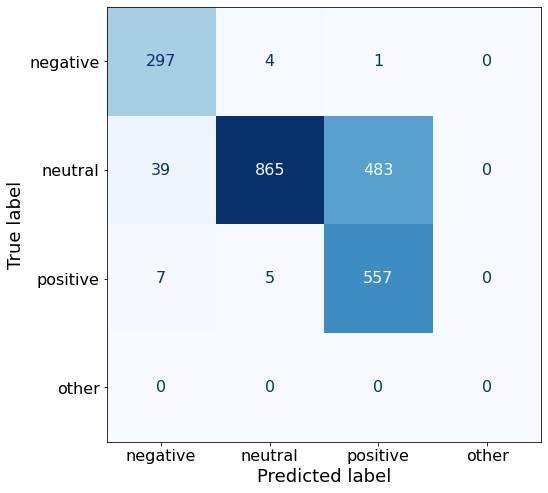

In [28]:
make_cm(df)

In [29]:
df.to_csv('/notebooks/phi-3_G.csv', index=False)

## Prompt H

I'll return to the 3-Shot prompt (82.62%) and see if I can improve it by adjusting the language.
First, I'll add some introductory text to the start of the prompt. Note that this did not improve the 0-Shot performance.

In [44]:
promptH = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.
Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral"""

In [14]:
exclude_idxs = [0, 1, 292]

examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples

[('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'),
 ("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 ('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
  'negative')]

In [20]:
promptF_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2261
})

In [47]:
df, acc = few_shot_responses(promptF_ds, promptH, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nInstruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nlabel the TEXT with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nInstruct: label the following TEXT with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nlabel the TEXT with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'positive'}, {'role': 'user', 'co

I get a tiny boost (0.48%) with this approach. I'll take it!

In [48]:
acc

0.8310482087571871

Compared to the previous 3-Shot prompt (82.62%), this prompt results in a
lower true positive rate for `negative` sentences (296 < 297), 
a slightly higher rate for `neutral` sentences (1021 > 1009),
and the same rate for `positive` sentences (562).

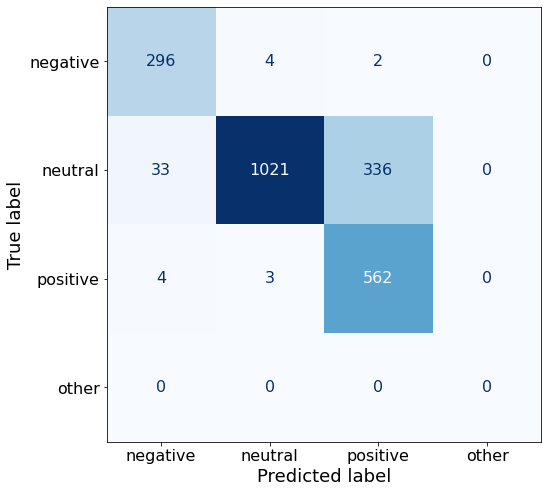

In [51]:
make_cm(df)

In [52]:
df.to_csv('/notebooks/phi-3_H.csv', index=False)

## Prompt I

Given my success with the language adjustment for 3-Shot prompting, 
I'll make another one: adding a period to the end of each instruction sentence.

In [53]:
promptI = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.
Instruct: label the following TEXT with a single word: negative, positive, or neutral.
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral."""

In [56]:
df, acc = few_shot_responses(promptF_ds, promptI, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nInstruct: label the following TEXT with a single word: negative, positive, or neutral.\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nlabel the TEXT with a single word: negative, positive, or neutral."}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nInstruct: label the following TEXT with a single word: negative, positive, or neutral.\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nlabel the TEXT with a single word: negative, positive, or neutral."}, {'role': 'assistant', 'content': 'positive'}, {'role': 'user',

Surprisingly, adding periods at the end of the instructions actually reduces the overall 
accuracy (81.16%).

In [57]:
acc

0.8115877930119416

The true positive rate drops for `negative` (295 < 296) and `neutral` (977 < 1021) 
but increases for `positive` (563 > 562) when compared to the best-performing prompt.

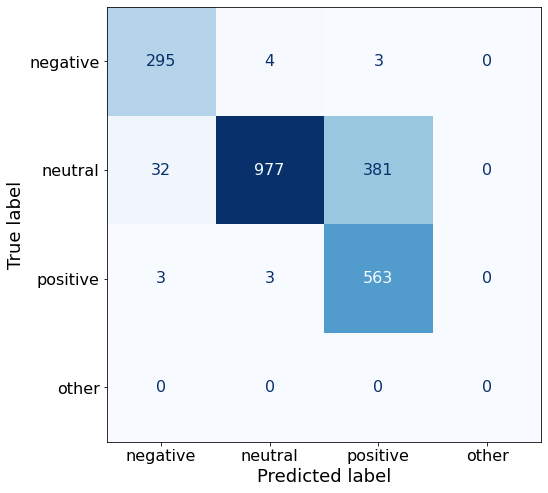

In [58]:
make_cm(df)

In [59]:
df.to_csv('/notebooks/phi-3_I.csv', index=False)

## Prompt J

I'll try another language adjustment for the few-shot prompt: replacing 
"Instruct: label the TEXT with a single word: negative, positive, or neutral." with 
"Respond with a single word: negative, positive, or neutral".

In [15]:
promptJ = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.
Respond with a single word: negative, positive, or neutral
TEXT: {text}
Respond with a single word: negative, positive, or neutral"""

In [64]:
df, acc = few_shot_responses(promptF_ds, promptJ, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nRespond with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nRespond with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'positive'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's p

Yes!! I achieve my best result so far with 84.6% overall accuracy.

In [65]:
acc

0.8460858027421495

Compared to Prompt H, this prompt yields a worse `negative` sentiment true positive rate 
(294 < 296), but a better rate for `neutral` (1055 > 1021) and `positive` (564 > 562).

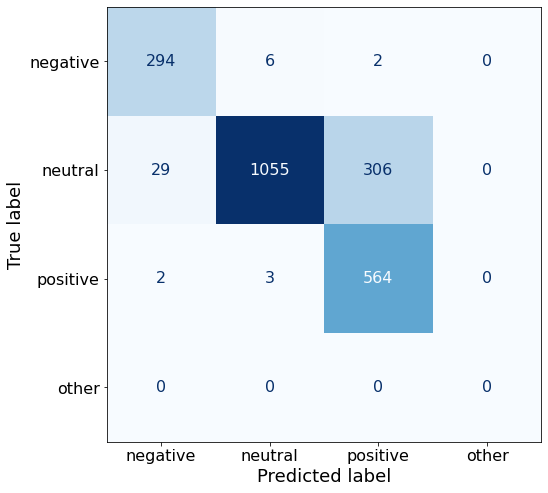

In [66]:
make_cm(df)

In [67]:
df.to_csv('/notebooks/phi-3_J.csv', index=False)

## Prompt K

Another language adjustment that worked for phi-2: adding the phrase "if you're not sure, respond with neutral".

In [86]:
promptK = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.
Respond with a single word: negative, positive, or neutral. If you're not sure, respond with neutral.
TEXT: {text}
Respond with a single word: negative, positive, or neutral. If you're not sure, respond with neutral."""

In [87]:
df, acc = few_shot_responses(promptF_ds, promptK, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral. If you're not sure, respond with neutral.\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nRespond with a single word: negative, positive, or neutral. If you're not sure, respond with neutral."}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral. If you're not sure, respond with neutral.\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nRespond with a single word: negative, positive, or neutral. If you'

This does not improve the overall accuracy.

In [88]:
acc

0.8319327731092437

Compared to Prompt J, this prompt results in a higher true positive rate for 
`negative` sentiment (295 > 294), but a lower rate for `neutral` (1024 < 1055) and
`positive` sentiment (562 < 564).

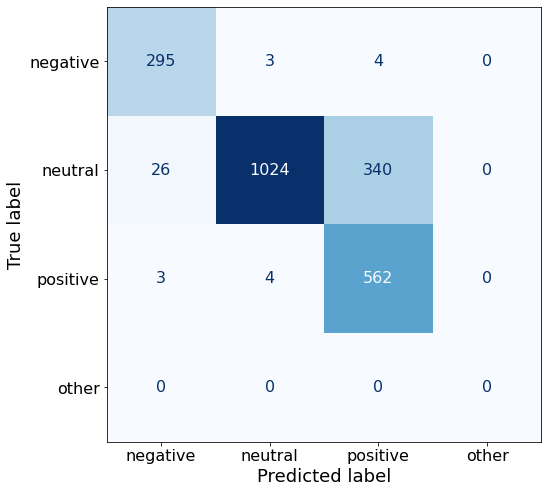

In [89]:
make_cm(df)

In [90]:
df.to_csv('/notebooks/phi-3_K.csv', index=False)

## Prompt L

I'll see if adding a system prompt improves performance.

In [76]:
#| code-fold: true
#| code-summary: "Show updated `few_shot_responses` function"
def few_shot_responses(dataset, prompt, examples, sp=False):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})

    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    count = 0
    for row in dataset:
        count += 1
        
        if sp:
            messages = [{'role': 'system', 'content': 'You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification.'}
                       ] + few_shot_examples + [{"role": "user", "content": row['prompt']}]
        else:
            messages = few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        if count == 1: print(messages)
        
        generation_args = { 
            "max_new_tokens": 2, 
            "return_full_text": False, 
            "temperature": 0.1, 
            "do_sample": True, 
        } 

        response = pipe(messages, **generation_args) 
        responses.append(response[0]['generated_text'].strip().lower())
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    return df, acc

In [79]:
df, acc = few_shot_responses(promptF_ds, promptJ, examples, sp=True)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'system', 'content': 'You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification.'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nRespond with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same per

Adding this sytem prompt increases the accuracy from 84.6% to 87.4%!

In [80]:
acc

0.8735072976559045

Compared to Prompt J (without system prompt) adding this system prompt results in 
a higher true positive rate for `negative` (295 > 294) and `neutral` (1120 > 1055) 
sentiment but a lower rate for `positive` sentiment (560 < 564).

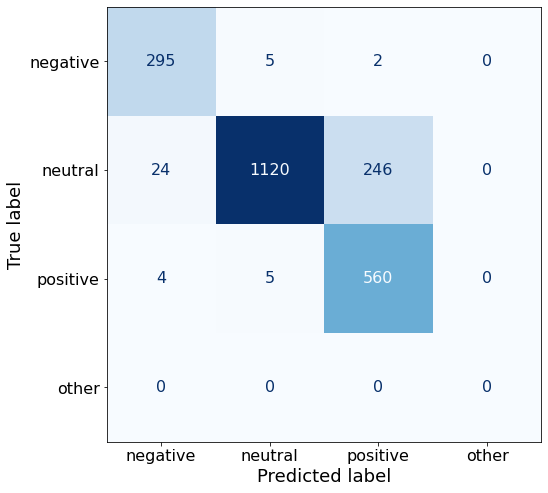

In [81]:
make_cm(df)

In [85]:
df.to_csv('/notebooks/phi-3_L.csv', index=False)

## Prompt M

I'll add the following phrase to the system prompt:

> If you're not sure, respond with neutral.

In [9]:
#| code-fold: true
#| code-summary: "Show updated `few_shot_responses` function"
def few_shot_responses(dataset, prompt, examples, sp=False):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})

    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    count = 0
    for row in dataset:
        count += 1
        
        if sp:
            messages = [{'role': 'system', 'content': sp}] + few_shot_examples + [{"role": "user", "content": row['prompt']}]
        else:
            messages = few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        if count == 1: print(messages)
        
        generation_args = { 
            "max_new_tokens": 2, 
            "return_full_text": False, 
            "temperature": 0.1, 
            "do_sample": True, 
        } 

        response = pipe(messages, **generation_args) 
        responses.append(response[0]['generated_text'].strip().lower())
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    return df, acc

In [96]:
sp = "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If you're not sure, respond with neutral."

In [97]:
print(sp)

You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If you're not sure, respond with neutral.


In [98]:
df, acc = few_shot_responses(promptF_ds, promptJ, examples, sp=sp)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'system', 'content': "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If you're not sure, respond with neutral."}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nRespond with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubl

Excellent---the new system prompt results in the best-so-far overall accuracy (88.4%).

In [99]:
acc

0.8841220698805838

Compared to the last system prompt, this one yields a lower true positive rates for `negative` sentiment
(292 < 295) and `positive` sentiment (558 < 560) but a higher rate for `neutral` (1149 > 1120) sentiment.

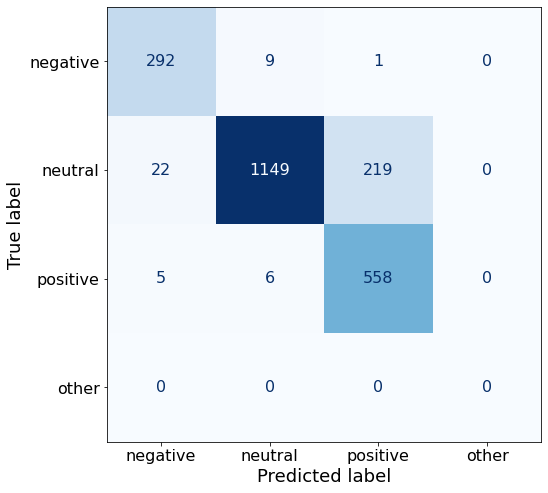

In [100]:
make_cm(df)

In [101]:
df.to_csv('/notebooks/phi-3_M.csv', index=False)

## Prompt N

I'll iterate on the system prompt. I'll replace:

> If you're not sure, respond with neutral.

with

> If the amount of money is not explicitly increasing or decreasing, respond with neutral.

In [105]:
sp = "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money is not explicitly increasing or decreasing, respond with neutral."

In [106]:
print(sp)

You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money is not explicitly increasing or decreasing, respond with neutral.


In [107]:
df, acc = few_shot_responses(promptF_ds, promptJ, examples, sp=sp)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'system', 'content': 'You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money is not explicitly increasing or decreasing, respond with neutral.'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nRespond with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: For the last 

The updated system prompt causes the overall accuracy to drop a tiny bit.

In [108]:
acc

0.8827952233524989

The true positive rate for `negative` (293 > 292) and `positive` (561 > 558) sentiment actually increases, 
but decreases for `neutral` sentiment (1142 < 1149) when compare to the previous system prompt.

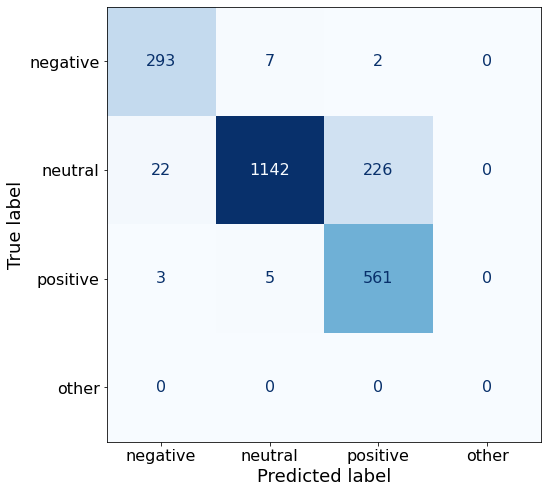

In [109]:
make_cm(df)

In [110]:
df.to_csv('/notebooks/phi-3_N.csv', index=False)

## Prompt O

I'll iterate on the best-performing (88.4%) Prompt M by adding more detail to how the model
should handle neutral sentiment (based on a suggestion by Claude):

In [22]:
sp = "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral."

In [23]:
print(sp)

You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral.


In [24]:
df, acc = few_shot_responses(promptF_ds, promptJ, examples, sp=sp)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'system', 'content': 'You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral.'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nRespond with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negat

You are not running the flash-attention implementation, expect numerical differences.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Nice! This modification resulted in the best overall accuracy so far, 88.6%.

In [25]:
acc

0.885891198584697

The true positive rate increased for `negative` and `positive` sentiments and decreased
a bit for `neutral` sentiment.

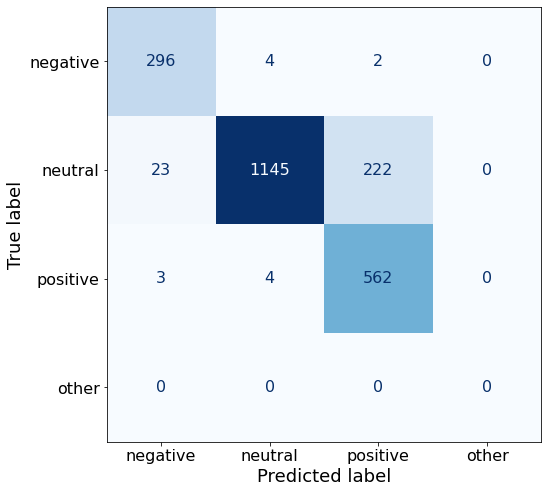

In [26]:
make_cm(df)

In [27]:
df.to_csv('/notebooks/phi-3_O.csv', index=False)

## Prompt P

Given the improvement with a more nuanced system prompt, I'll continue adding to the prompt.

In [13]:
sp = "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. Consider terms like 'growth', 'decline', 'improvement', or 'deterioration' as indicators of change."

In [14]:
print(sp)

You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. Consider terms like 'growth', 'decline', 'improvement', or 'deterioration' as indicators of change.


In [32]:
df, acc = few_shot_responses(promptF_ds, promptJ, examples, sp=sp)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

[{'role': 'system', 'content': "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. Consider terms like 'growth', 'decline', 'improvement', or 'deterioration' as indicators of change."}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .\nRespond with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content': 'neutral'}, {'role': 'user', 'content': "Your task is to analyze 

Awesome!! I've broken the 90% mark with that system prompt.

In [33]:
acc

0.9000442282176029

Compared to the previous best-performing prompt O, this prompt yields fewer correct
`negative` sentences (294 < 296), more correct `neutral` sentences (1179 > 1145) and thes
same number of correct `positive` sentences (562).

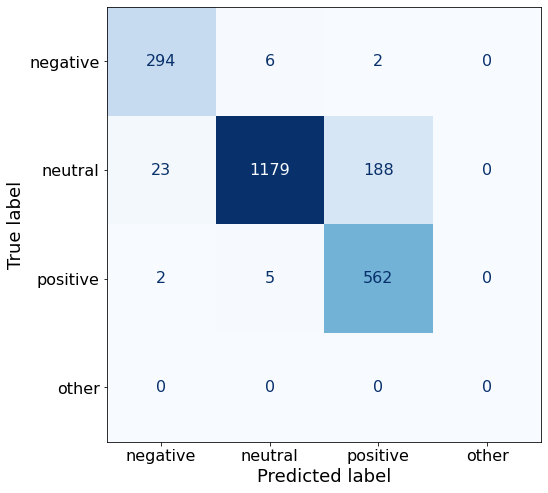

In [34]:
make_cm(df)

In [35]:
df.to_csv('/notebooks/phi-3_P.csv', index=False)

## Prompt Q

I'll now increase the number of examples to a significantly larger number (20) and see
if that improves performance.

In [37]:
exclude_idxs = [1, 2, 3, 4, 292, 293, 294, 347, 0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 274, 283]

In [38]:
promptQ_ds = ds_subset(dataset, exclude_idxs=exclude_idxs, columns=[0, 1, 2])
promptQ_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2244
})

In [39]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples[0], len(examples)

(("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 20)

In [40]:
df, acc = few_shot_responses(promptQ_ds, promptJ, examples, sp=sp)

Map:   0%|          | 0/2244 [00:00<?, ? examples/s]

[{'role': 'system', 'content': "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. Consider terms like 'growth', 'decline', 'improvement', or 'deterioration' as indicators of change."}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nRespond with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content':

Another improvement! I am now pretty close to phi-2's accuracy (91.94%).

In [41]:
acc

0.9171122994652406

Compared to Prompt P, this prompt yields a lower true positive rate for `negative` (291 < 294) 
and `positive` (541 < 562) sentiment but more than compensates for that with an increased 
true positive rate for `neutral` sentiment (1226 > 1179).

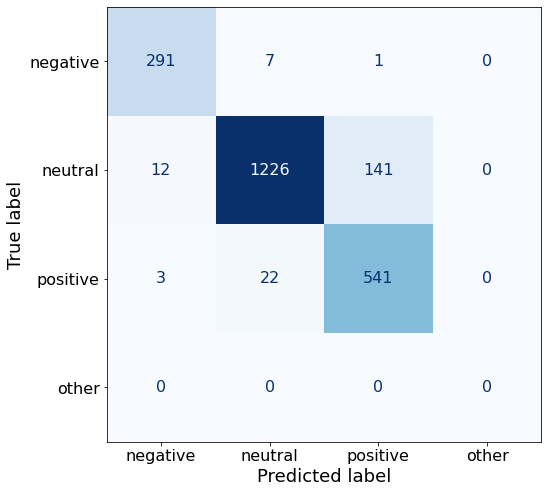

In [42]:
make_cm(df)

In [43]:
df.to_csv('/notebooks/phi-3_Q.csv', index=False)

## Prompt R

I'll increase the number of examples and see if that improves performance.

In [16]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, # positive
    292, 293, 294, 347, 348, 349, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 274, 283, 284, 285, 286, 287, 288, 289 # neutral
]

In [17]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples[0], len(examples)

(("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 30)

In [18]:
promptR_ds = ds_subset(dataset, exclude_idxs=exclude_idxs, columns=[0, 1, 2])
promptR_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2234
})

In [19]:
df, acc = few_shot_responses(promptR_ds, promptJ, examples, sp=sp)

Map:   0%|          | 0/2234 [00:00<?, ? examples/s]

[{'role': 'system', 'content': "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. Consider terms like 'growth', 'decline', 'improvement', or 'deterioration' as indicators of change."}, {'role': 'user', 'content': "Your task is to analyze the sentiment (from an investor's perspective) of the text below.\nRespond with a single word: negative, positive, or neutral\nTEXT: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .\nRespond with a single word: negative, positive, or neutral"}, {'role': 'assistant', 'content':

You are not running the flash-attention implementation, expect numerical differences.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


And with that I have surpassed phi-2!

In [20]:
acc

0.9279319606087735

Compared to Prompt P, this prompt yields a lower true positive rate for `negative` (290 < 294) 
and `positive` (499 < 562) sentiment but like Prompt Q, more than compensates for that with an increased 
true positive rate for `neutral` sentiment (1284 > 1179).

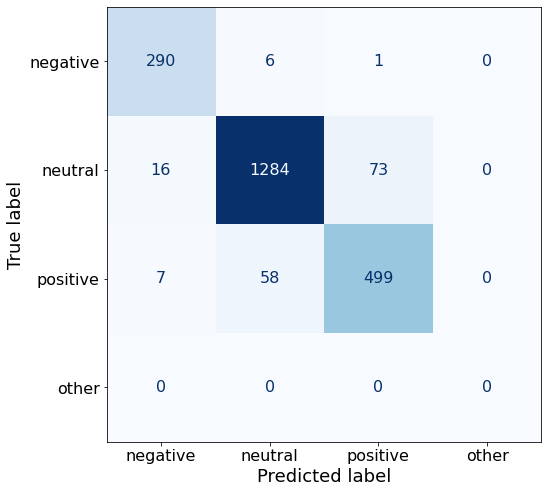

In [21]:
make_cm(df)

In [22]:
df.to_csv('/notebooks/phi-3_R.csv', index=False)

## Running Inference with the Best Prompt Multiple Times

In [9]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, # positive
    292, 293, 294, 347, 348, 349, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 274, 283, 284, 285, 286, 287, 288, 289 # neutral
]

In [10]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

30

In [11]:
promptR_ds = ds_subset(dataset, exclude_idxs=exclude_idxs, columns=[0, 1, 2])
promptR_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2234
})

In [12]:
promptJ = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.
Respond with a single word: negative, positive, or neutral
TEXT: {text}
Respond with a single word: negative, positive, or neutral"""

In [13]:
sp = "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. Consider terms like 'growth', 'decline', 'improvement', or 'deterioration' as indicators of change."

In [14]:
print(sp)

You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. Consider terms like 'growth', 'decline', 'improvement', or 'deterioration' as indicators of change.


In [18]:
#| code-fold: true
#| code-summary: "Show `test_gen` function"
def test_gen(examples, sp):
    responses = []

    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": promptJ.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    


    messages = [{'role': 'system', 'content': sp}] + few_shot_examples + [{"role": "user", "content": promptJ.format(text=dataset[0]['sentence'])}]


    generation_args = { 
        "max_new_tokens": 2, 
        "return_full_text": False, 
        "temperature": 0.1, 
        "do_sample": True, 
    } 

    response = pipe(messages, **generation_args) 
    responses.append(response[0]['generated_text'].strip().lower())
    return responses

The model takes about 1.64 seconds to generate a response for a single dataset item, or about 1.01 hours for the 2234 items (on a Paperspace Free-A4000). 
Given the 6 hour limit, the max I can do is run inference on the dataset 5 times. 

In [20]:
%timeit -n 10 test_gen(examples, sp)

1.64 s ± 3.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
#| code-fold: true
#| code-summary: "Show `few_shot_responses` function"
def few_shot_responses(dataset, prompt, examples, sp):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})

    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    for row in dataset:
        messages = [{'role': 'system', 'content': sp}] + few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        generation_args = { 
            "max_new_tokens": 2, 
            "return_full_text": False, 
            "temperature": 0.1, 
            "do_sample": True, 
        } 

        response = pipe(messages, **generation_args) 
        responses.append(response[0]['generated_text'].strip().lower())
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    return df, acc

In [ ]:
accs = []
for _ in range(5):
    df, acc = few_shot_responses(promptR_ds, promptJ, examples, sp)
    accs.append(acc)

The accuracy for this prompt is consistently around 92.7%.

In [3]:
pd.Series(accs).describe()

count    5.000000
mean     0.928111
std      0.000981
min      0.927484
25%      0.927484
50%      0.927484
75%      0.928380
max      0.929722
dtype: float64

## Final Thoughts

Here is a summary of results including phi-2, phi-3.5, and the Claude family:

|Model|Prompting Strategy|Overall Accuracy|`negative`|`neutral`|`positive`|
|:-:|:-:|:-:|:-:|:-:|:-:|
|claude-3-5-sonnet-20240620|3-Shot|94.78%|98% (297/303) | 94% (1302/1391)|95% (544/570)|
|claude-3-opus-20240229|0-Shot|94.13%|98% (297/303)|96% (1333/1391)|88% (501/570)|
|phi-3.5|20-Shot|93.94%|96% (286/299)|98% (1355/1379)|83% (467/566)|
|phi-3|30-Shot w/System Prompt|92.79%|98% (290/297)|94% (1284/1373)|88% (499/564)|
|claude-3-haiku-20240307|3-Shot|92.39%|90% (272/303)|91% (1267/1391)|96% (550/570)|
|phi-2|6-Shot|91.94%|88% (267/302)|94% (1299/1387)|90% (510/569)|

Here is a summary of results from this notebook:

|prompt|strategy|accuracy|negative|neutral|positive|
|:-:|:-:|:-:|:-:|:-:|:-:|
|[A](#prompt-A)|0-Shot|47.00%|98% (298/303)|16% (220/1391)|96% (546/570)|
|[B](#prompt-B)|0-Shot|73.23%|99% (300/303)|59% (821/1391)|94% (537/570)|
|[C](#prompt-C)|0-Shot|66.25%|99% (300/303)|47% (650/1391)|96% (550/570)|
|[D](#prompt-D)|0-Shot|49.65%|<u>**99% (301/303)**</u>|19% (269/1391)|97% (554/570)|
|[E](#prompt-E)|0-Shot|72.44%|99% (299/303)|58% (803/1391)|94% (538/570)|
|[F](#prompt-F)|3-Shot|82.62%|98% (297/302)|73% (1009/1390)|99% (562/569)|
|[G](#prompt-G)|6-Shot|76.13%|98% (297/302)|62% (865/1387)|98% (557/569)|
|[H](#prompt-H)|3-Shot|83.10%|98% (296/302)|73% (1021/1390)|99% (562/569)|
|[I](#prompt-I)|3-Shot|81.16%|98% (295/302)|70% (977/1390)|99% (563/569)|
|[J](#prompt-J)|3-Shot|84.61%|97% (294/302)|76% (1055/1390)|<u>**99% (564/569)<u>**|
|[K](#prompt-K)|3-Shot|83.19%|98% (295/302)|74% (1024/1390)|99% (562/569)|
|[L](#prompt-L)|3-Shot w/System Prompt|87.35%|98% (295/302)|81% (1120/1390)|98% (560/569)|
|[M](#prompt-M)|3-Shot w/System Prompt|88.41%|97% (292/302)|83% (1149/1390)|98% (558/569)|
|[N](#prompt-N)|3-Shot w/System Prompt|88.28%|97% (293/302)|82% (1142/1390)|99% (561/569)|
|[O](#prompt-O)|3-Shot w/System Prompt|88.59%|98% (296/302)|82% (1145/1390)|99% (562/569)|
|[P](#prompt-P)|3-Shot w/System Prompt|90.00%|97% (294/302)|85% (1179/1390)|99% (562/569)|
|[Q](#prompt-Q)|20-Shot w/System Prompt|91.71%|97% (291/299)|89% (1226/1379)|96% (541/566)|
|<u>**[R](#prompt-R)**</u>|<u>**30-Shot w/System Prompt**</u>|<u>**92.79%**</u>|98% (290/297)|<u>**94% (1284/1373)**</u>|88% (499/564)|

I ran inference for phi-3 and phi-3.5 in separate notebooks at the same time, so I have shared final thoughts for both:

- **Few-shot prompting in a chat format is a different experience**: The sentence/label pairs have to be presented as a multi-turn conversation. For a large number of examples, this can lead to running out of GPU memory (as it did for 30-Shot prompting with phi-3.5).
- **Few-shot example proportion matters**: I used a higher proportion of neutral examples in my 20-shot prompt since the majority of the dataset is made up of `neutral` sentences. Determining whether the proportion I used is optimal would require further experimentation.
- **30-Shot phi-3 surpassed 6-Shot phi-2**: Although it took more experimentation than I expected to do so. I was honestly expecting to try a couple of prompts and easily beat phi-2. I did not try a 30-Shot prompt with phi-2, so it may have performed equally well (or better). I'm not convinced that 24 more examples and 50% more parameters to yield ~0.8% more accuracy is worth it.
- **30-Shot phi-3 surpassed 3-Shot Claude-3-Haiku**: Again, I did not try 30-Shot prompting with Haiku, so it very well could have performed better. Regardless, I was not expecting phi-3 to beat Haiku's score.
- **The best performing prompt suffers from a low true positive rate for `positive` sentiments**: Although the 30-Shot phi-3 prompt achieved the highest true positive rate (TPR) for `neutral` sentences (94%), it had the lowest TPR for `positive` sentences (88%). It's unclear if this is due to the imbalance between `positive` and `neutral` examples, since the TPR for `negative` sentiment is high (98%) despite having the same number of examples (6) as `positive`.
- **phi-3 performed differently than phi-3.5**: phi-3 performed well with a system prompt while phi-3.5 did not. On the other hand, phi-3.5 performed better with 0-Shot prompting than phi-3 (results not shown here).
**Future work**: My next step is to run inference on this dataset using the Qwen2-1.5B model. After that, I'll analyze the errors, especially for sentences that a majority of models classified incorrectly. With prompt engineering, there is potentially unlimited future work. Before I finish this project, I'll try 30-Shot prompts for phi-2 and Haiku to see if they can beat phi-3's 92.79% overall accuracy (and maybe even phi-3.5's 93.94% accuracy).

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).